In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

In [3]:
df = pd.read_csv('store_sales.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [4]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [6]:
df.set_index('date', inplace=True)

In [7]:
missing_data(df)

,Total,Percent,Types
id,0,0.0,int64
store_nbr,0,0.0,int64
family,0,0.0,object
sales,0,0.0,float64
onpromotion,0,0.0,int64


Data Visualisation

In [8]:
###Aggregating by category (family) & date
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

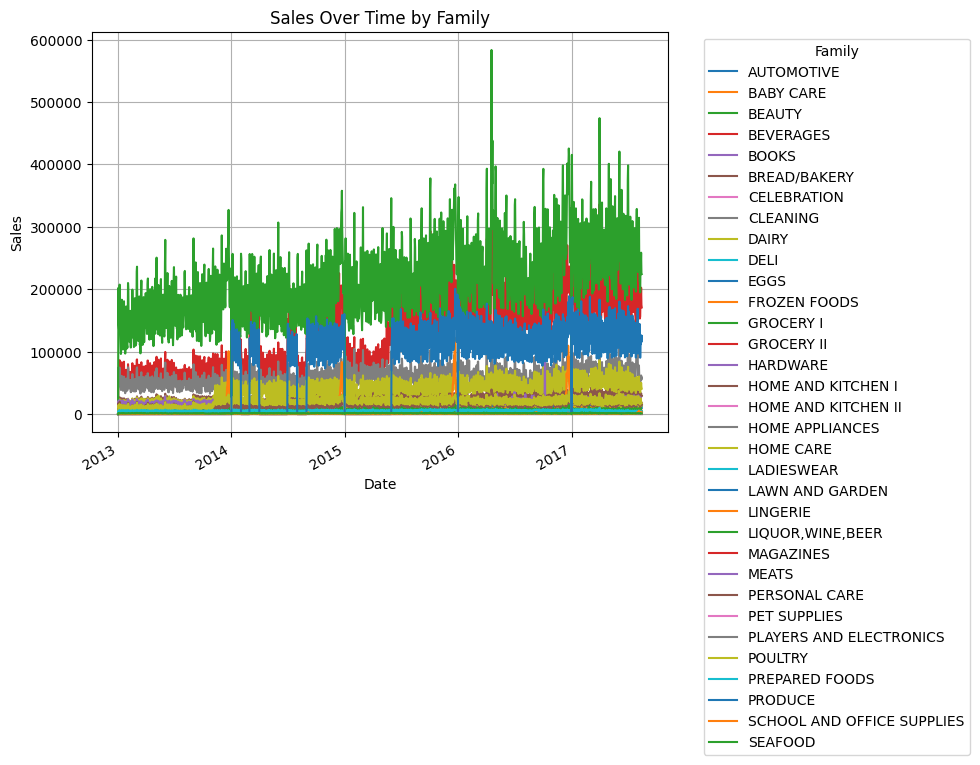

In [10]:
pivot_df = agg_df.pivot(index='date', columns='family', values='sales')

ax = pivot_df.plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time by Family')
plt.grid(True)
ax.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Denis\AppData\Local\Temp\ipykernel_994832\1759841149.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(pivot_df.columns))


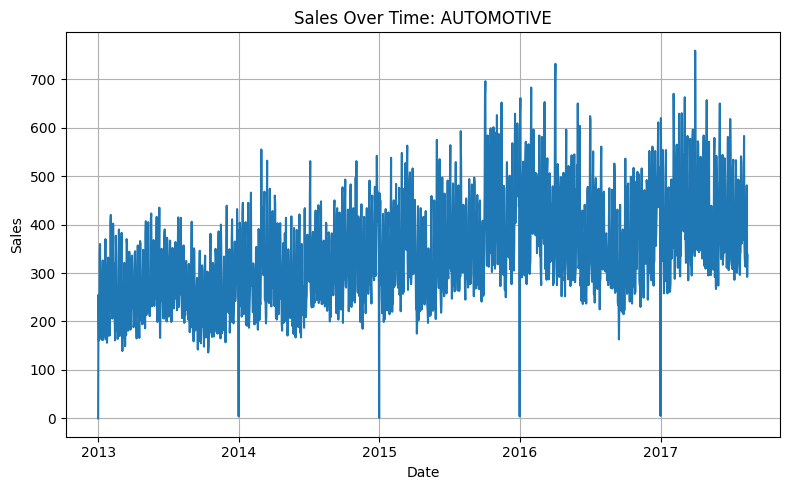

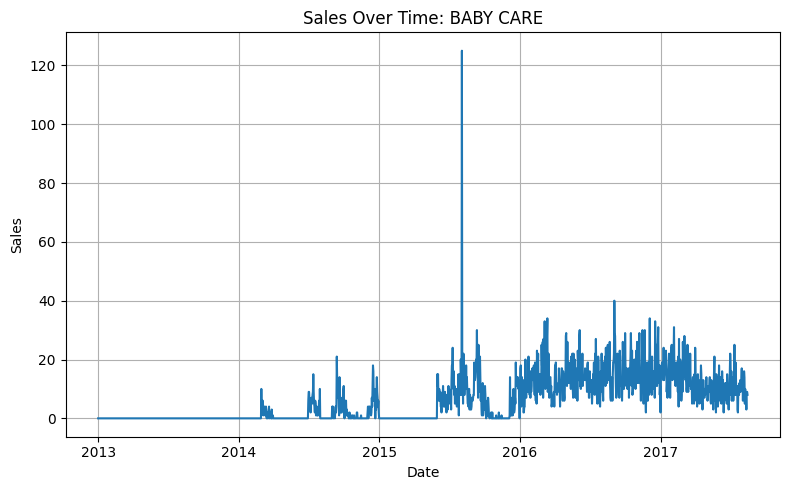

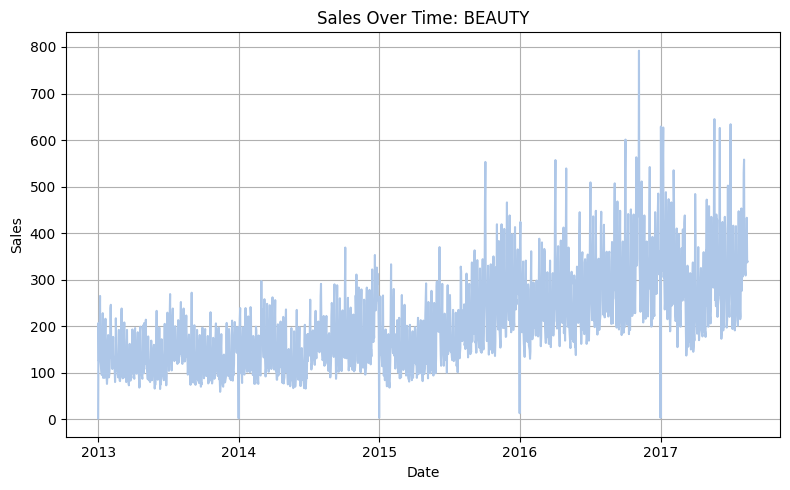

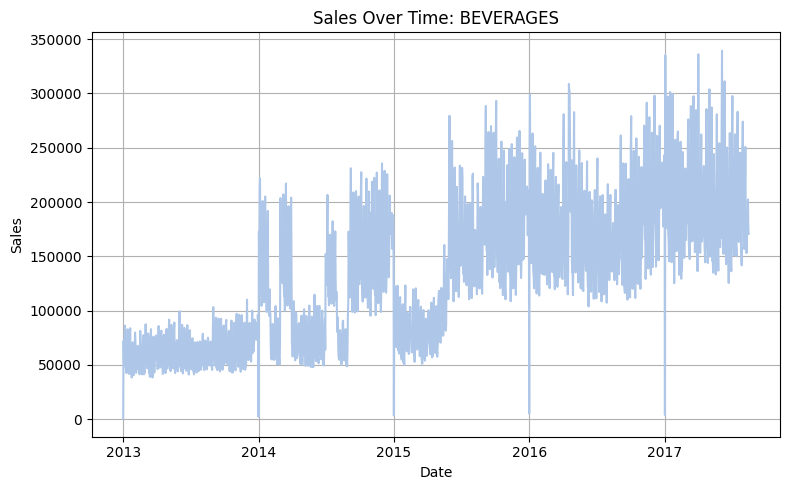

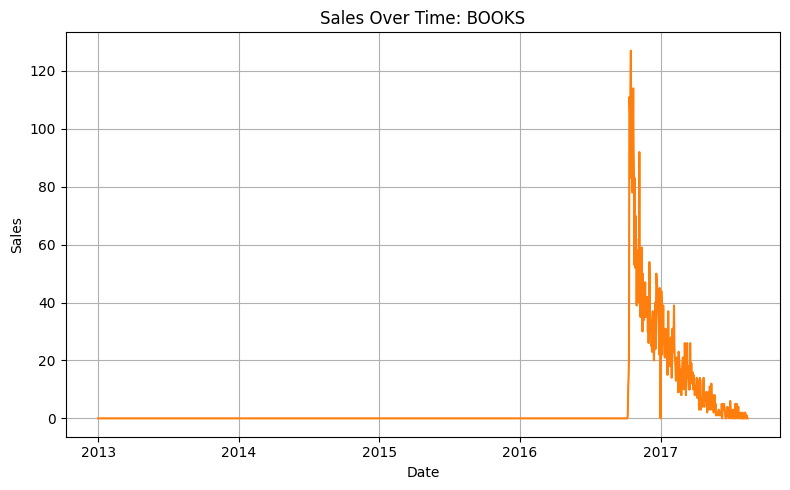

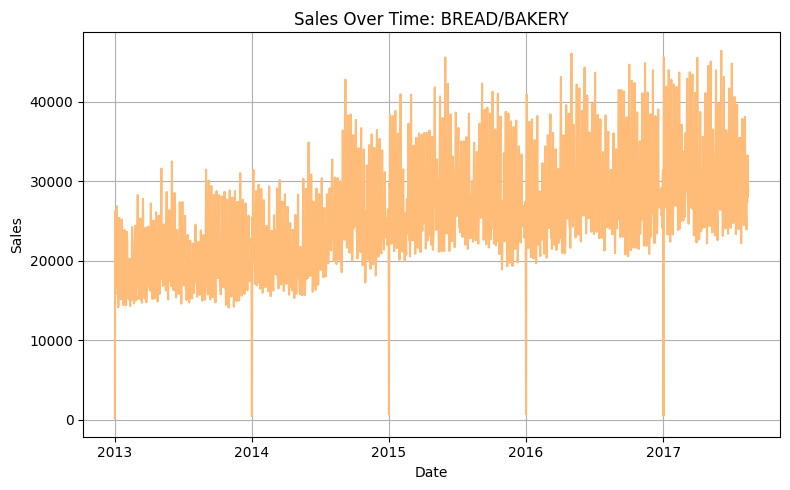

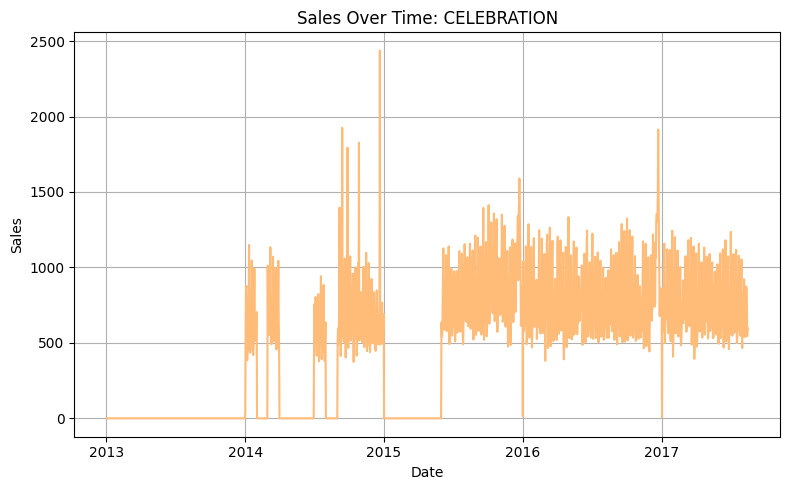

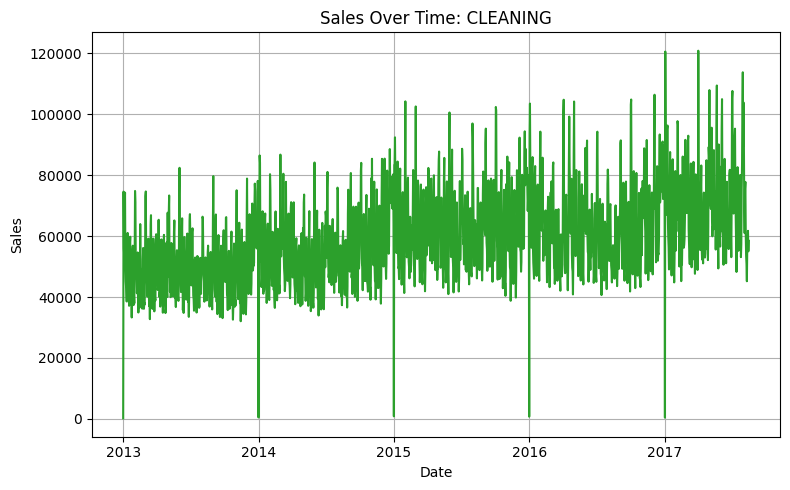

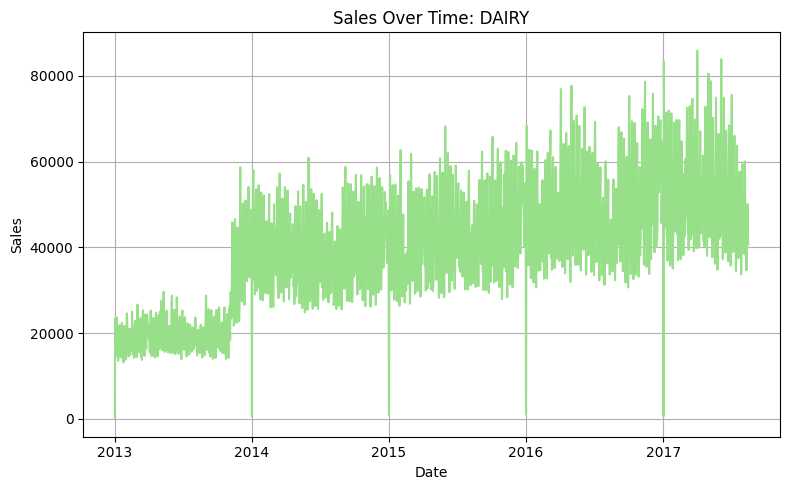

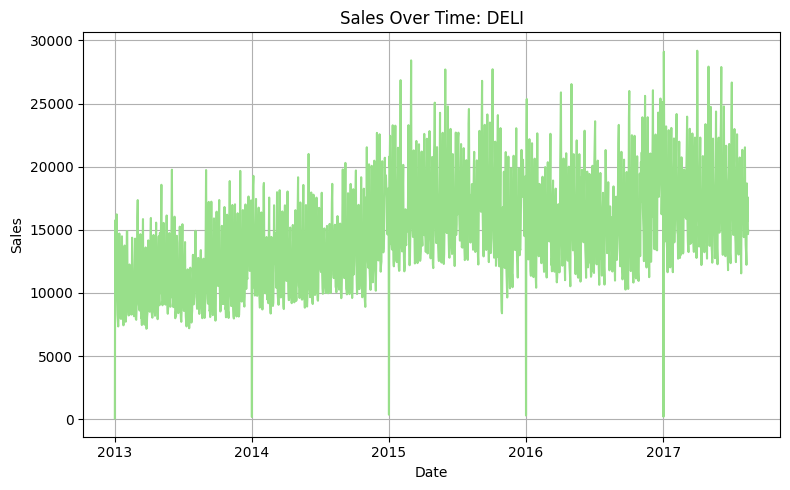

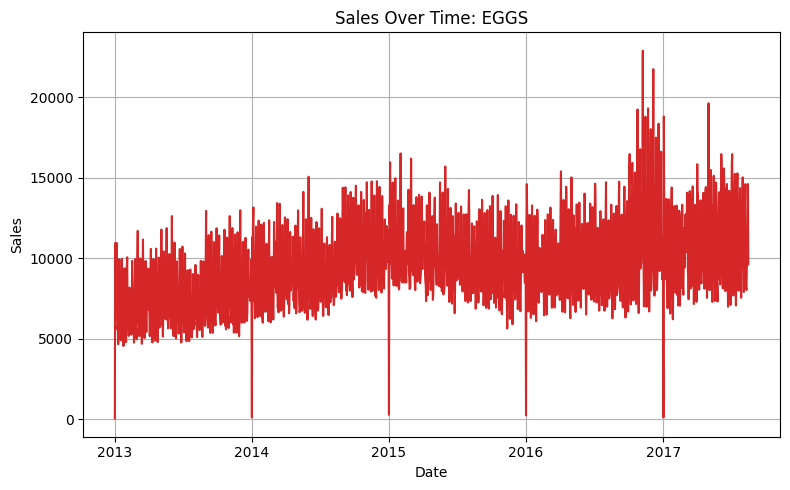

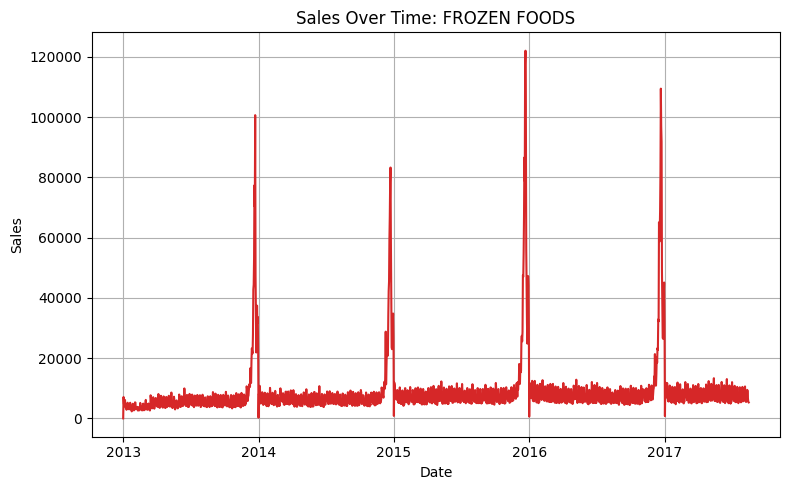

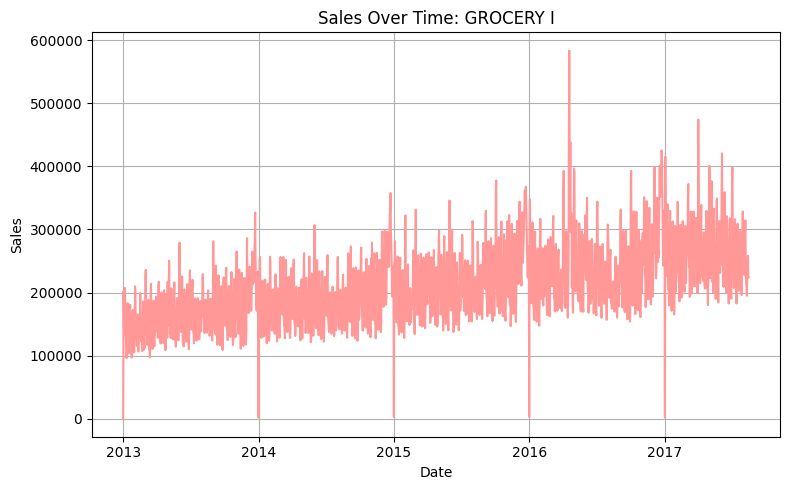

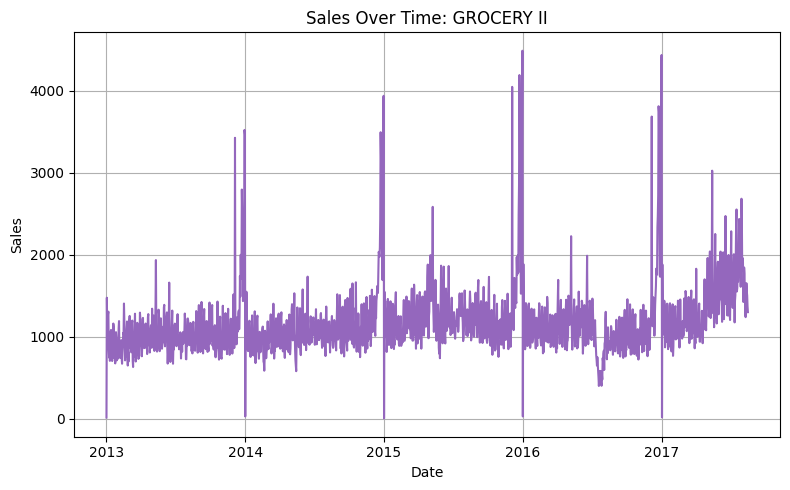

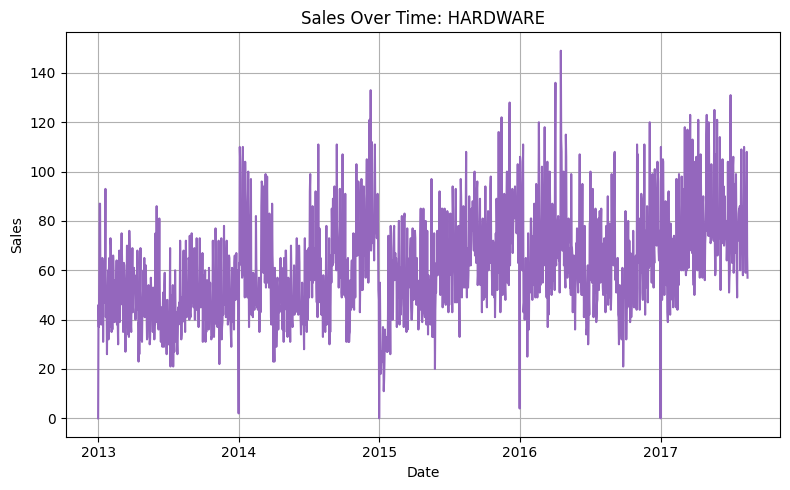

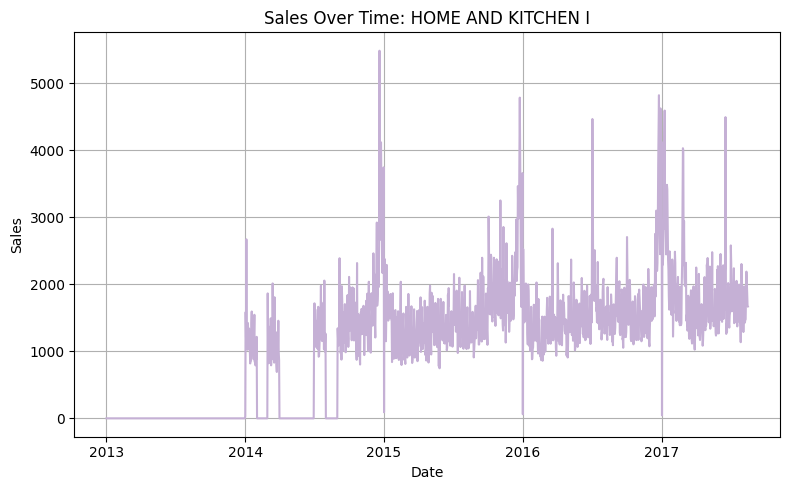

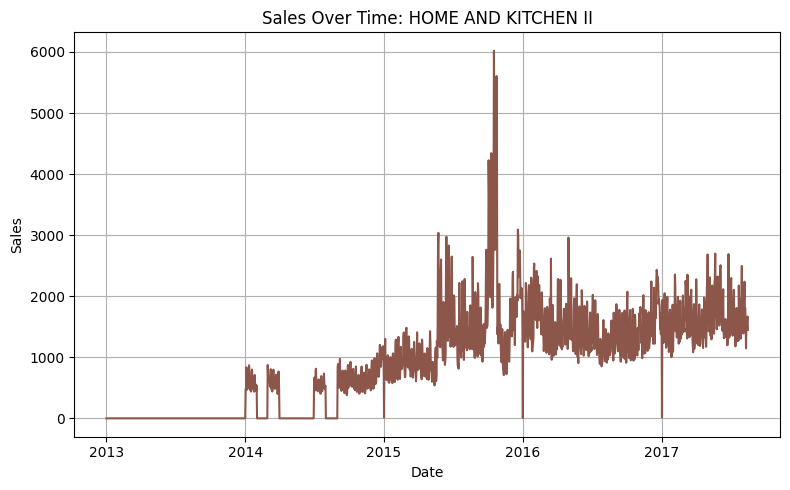

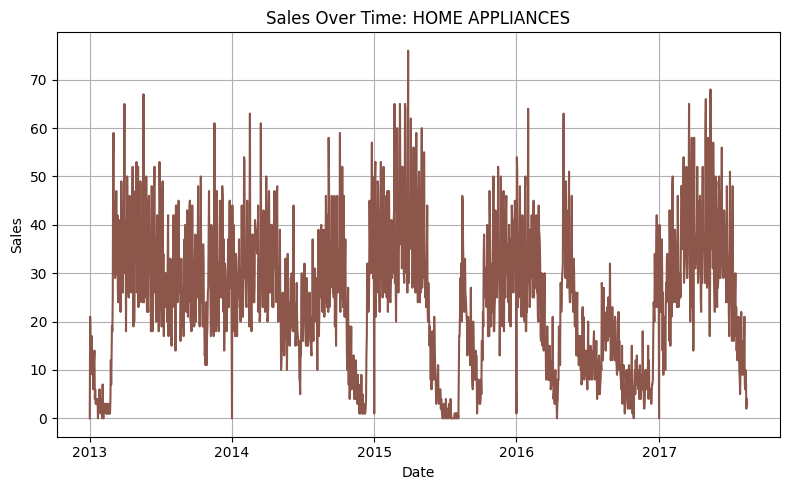

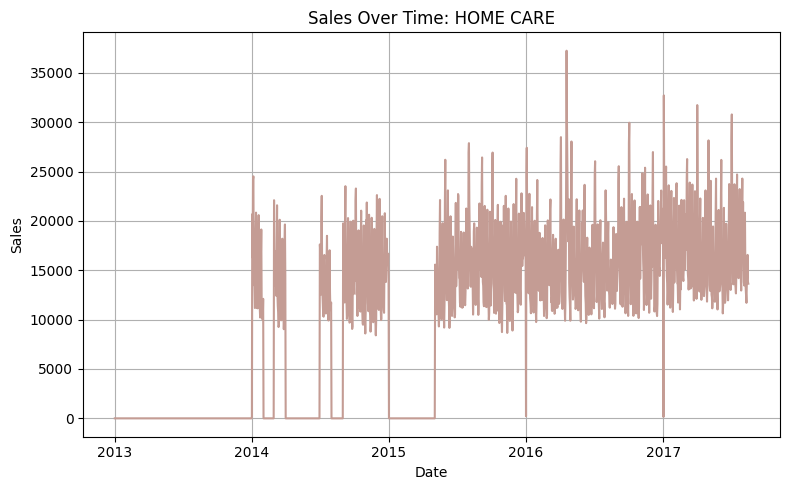

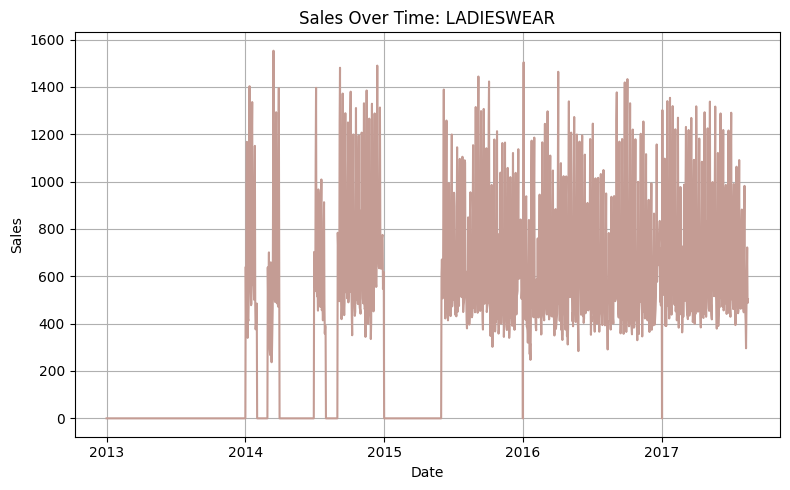

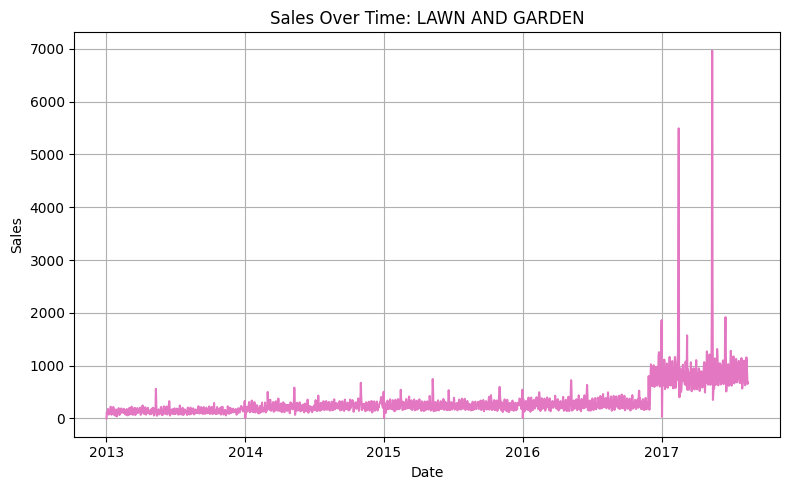

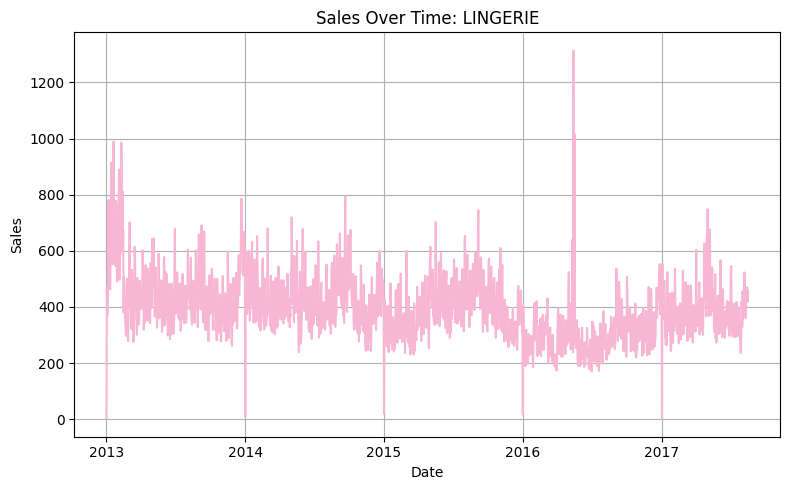

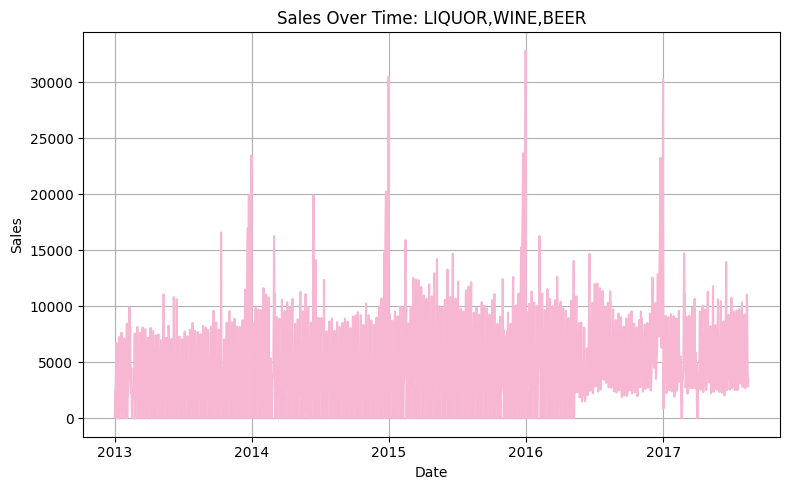

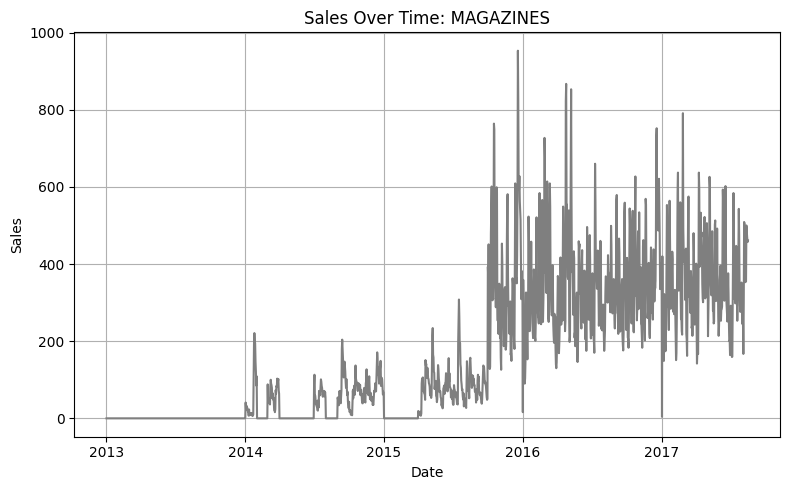

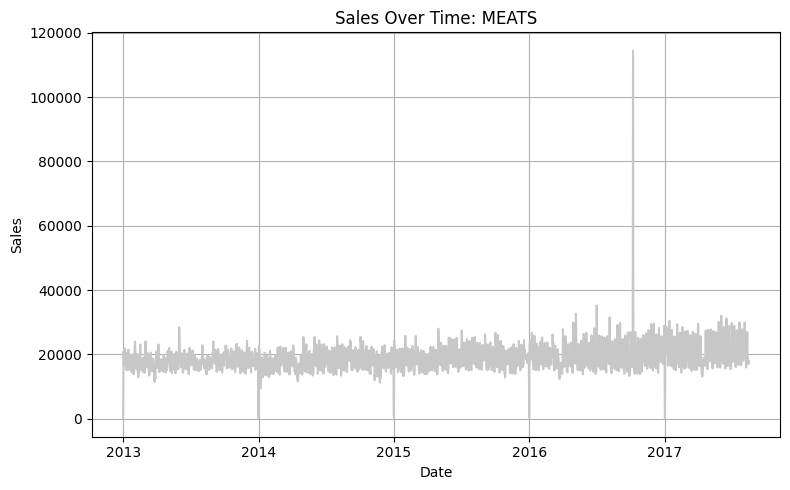

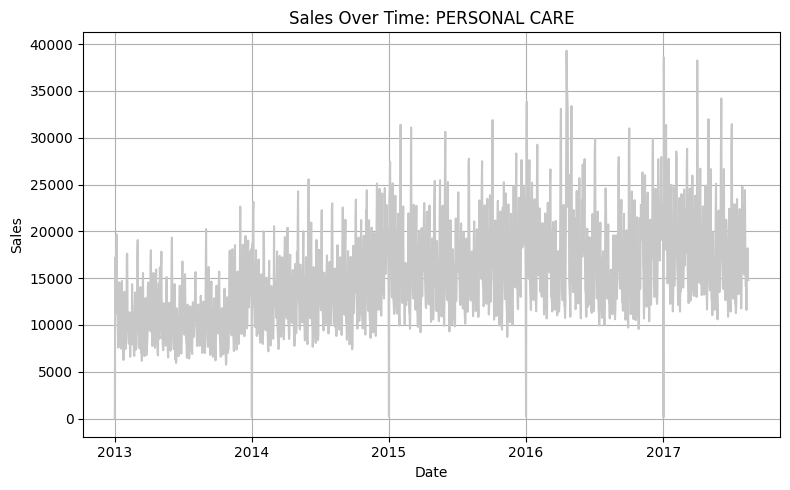

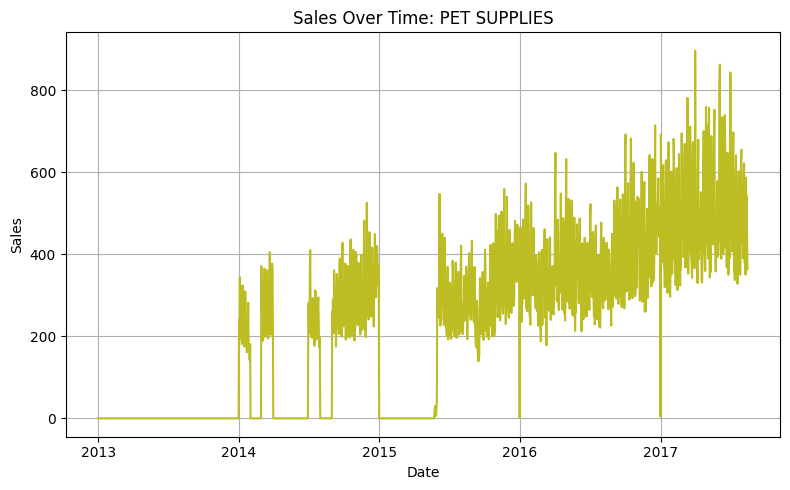

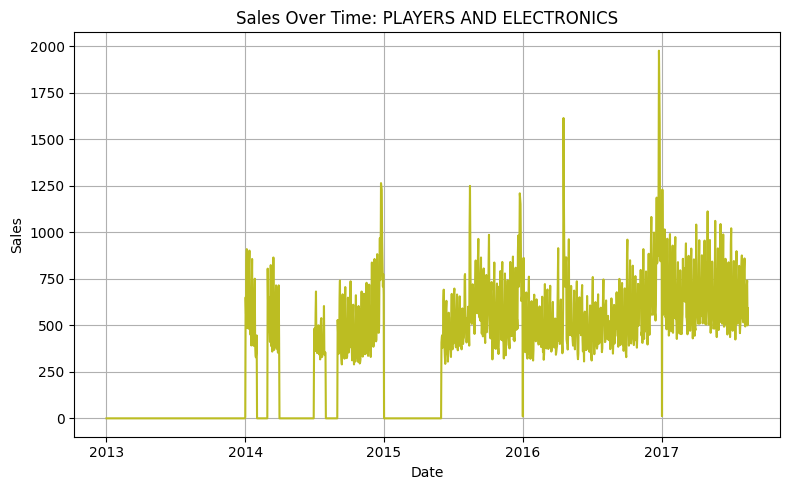

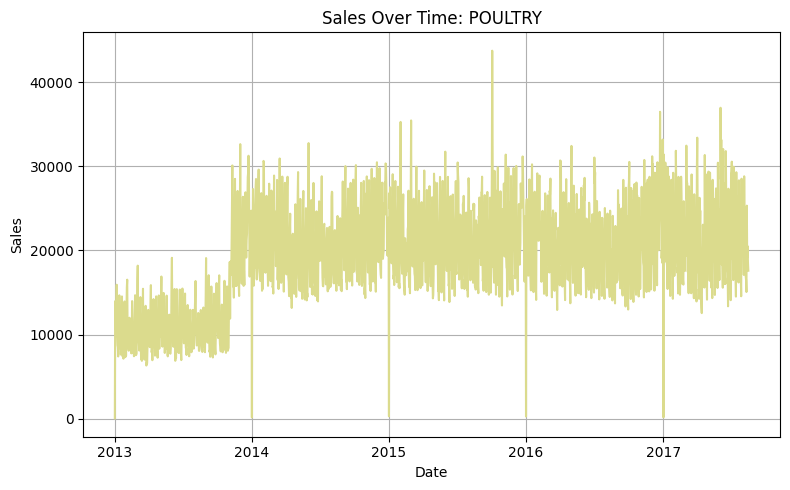

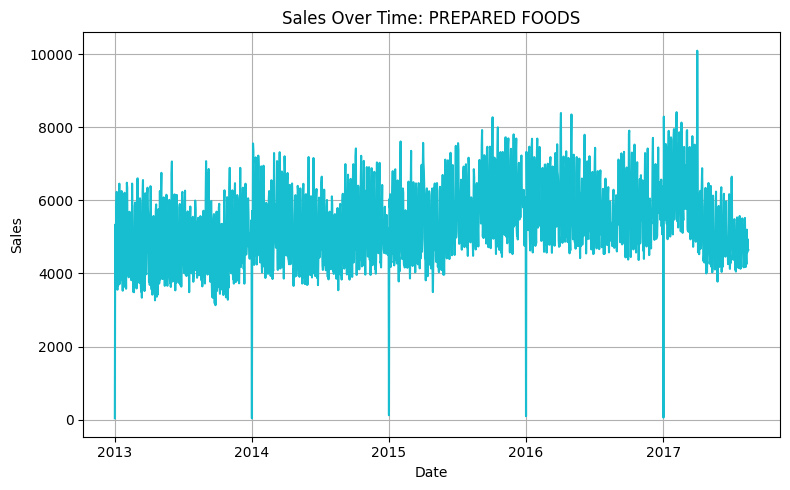

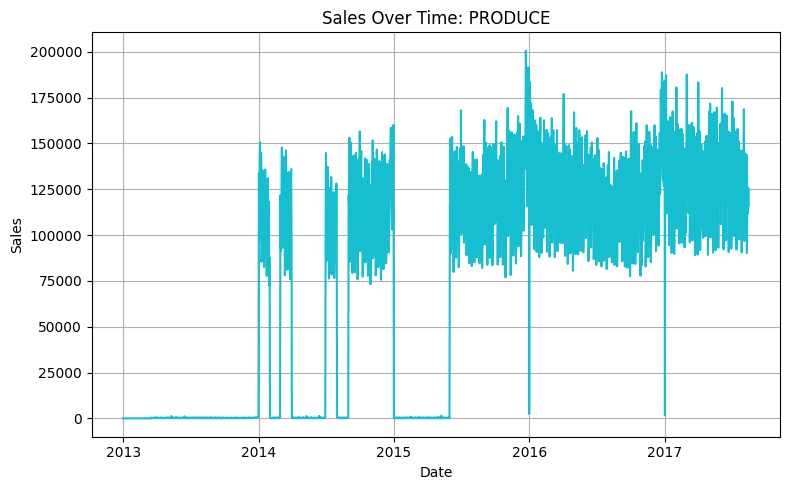

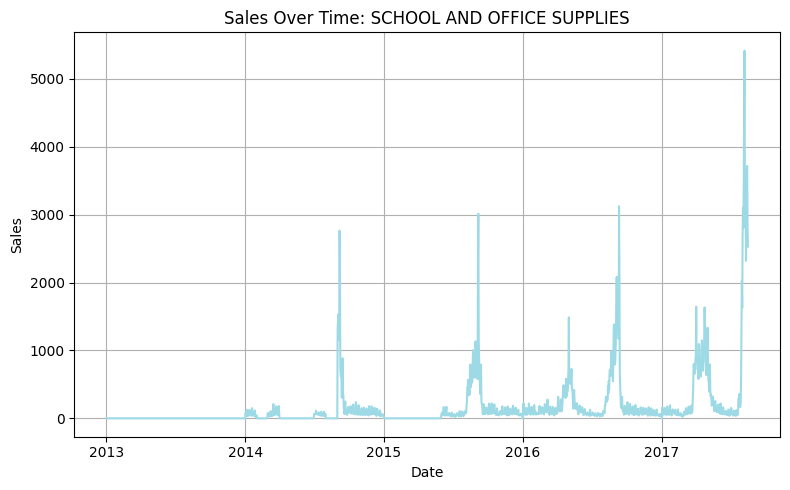

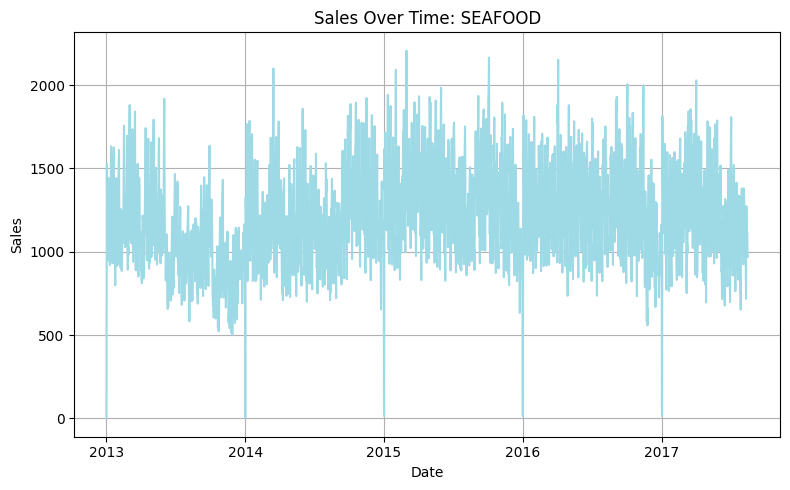

In [11]:
#Separate plots by category (family)
cmap = cm.get_cmap('tab20', len(pivot_df.columns))

for i, column in enumerate(pivot_df.columns):
    plt.figure(figsize=(8, 5))
    plt.plot(pivot_df.index, pivot_df[column], color=cmap(i))
    plt.title(f"Sales Over Time: {column}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Data from June 2015 and before tends to either be missing or insufficient

In [12]:
min(agg_df['date']), max(agg_df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

We'll stick to the below periods for consistency

Test period will be **2017-06-15** to **2017-08-15**

Training period will be **2015-06-15** to **2017-06-14**

In [13]:
df2 = df[df.index>='2015-06-15']

In [14]:
grouped = df2.groupby(['date', 'family'])[['sales', 'onpromotion']].sum().reset_index().sort_values(['family','date'])

Let's stick to a few categories that have a good amount of sales first.

In [38]:
selected_families = [
    'PRODUCE','POULTRY'
]

In [39]:
filtered = grouped[grouped['family'].isin(selected_families)]
family_dfs = {
    family: df.reset_index(drop=True) 
    for family, df in filtered.groupby('family')
}

In [40]:
for family in family_dfs:
    family_dfs[family]['date'] = pd.to_datetime(family_dfs[family]['date'])
    family_dfs[family] = family_dfs[family].sort_values('date').set_index('date')

In [54]:
produce_df = family_dfs['PRODUCE']
poultry_df = family_dfs['POULTRY']

In [37]:
### ADF Test to check for Stationarity

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)


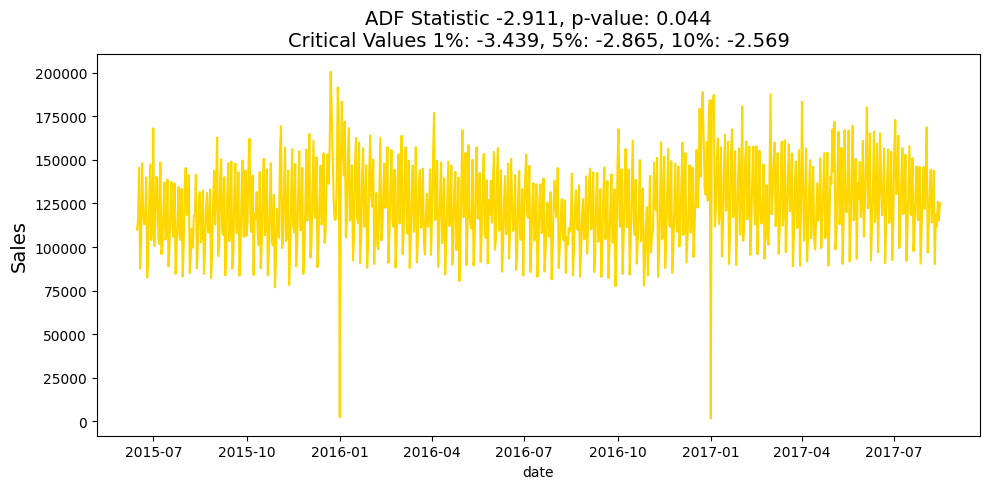

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_adfuller_results(produce_df['sales'], 'Sales', ax=ax)
plt.tight_layout()
plt.show()

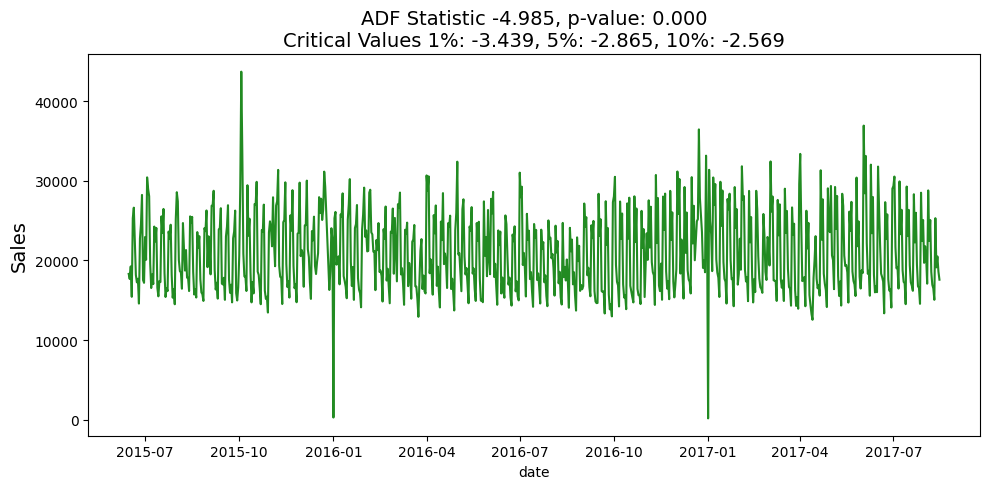

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
visualize_adfuller_results(poultry_df['sales'], 'Sales', ax=ax)
plt.tight_layout()
plt.show()

In [44]:
tss = TimeSeriesSplit(n_splits = 3, test_size = 60, gap = 0)
rmse_scores=[]
best_rmse = float('inf')
best_forecast = None
best_test_actual = None
best_test_index = None

In [46]:
produce_df = produce_df.asfreq('D') 
produce_df = produce_df.fillna(method='ffill')

In [49]:
for fold, (train_index, test_index) in enumerate(tss.split(produce_df)):
    train_df = produce_df.iloc[train_index]
    test_df = produce_df.iloc[test_index]
    
    model = SARIMAX(
        endog=train_df['sales'],
        exog= None,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results = model.fit(disp=False)

    forecast = results.forecast(
        steps=len(test_df)
    )

    rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
    rmse_scores.append(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_forecast = forecast
        best_test_actual = test_df['sales']
        best_test_index = test_df.index
    
    print(f"Fold {fold + 1}: RMSE = {rmse:.2f}")

Fold 1: RMSE = 13356.33
Fold 2: RMSE = 15886.15
Fold 3: RMSE = 10245.56


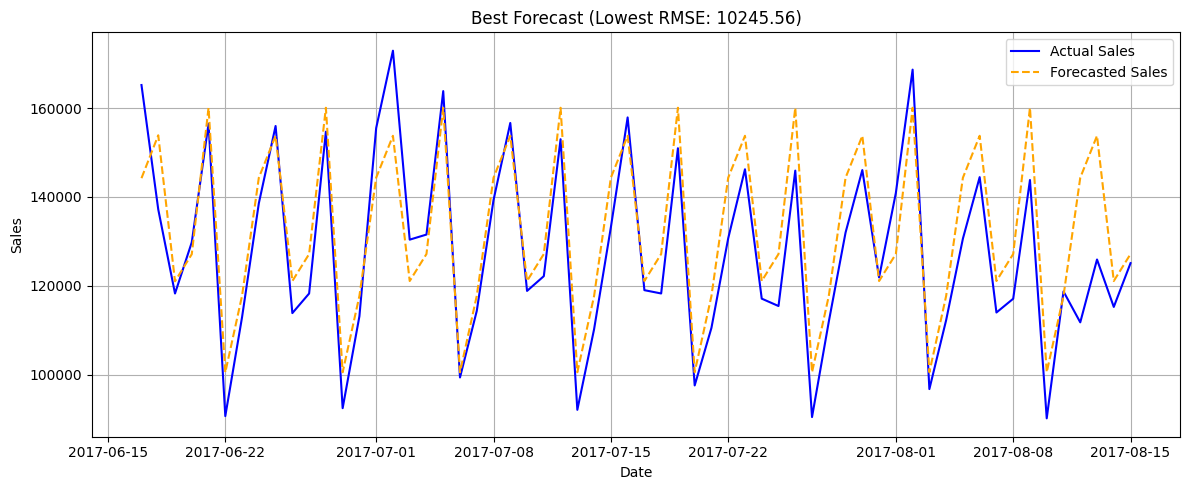

In [50]:
plt.figure(figsize=(12, 5))
plt.plot(best_test_index, best_test_actual, label='Actual Sales', color='blue')
plt.plot(best_test_index, best_forecast, label='Forecasted Sales', color='orange', linestyle='--')
plt.title(f'Best Forecast (Lowest RMSE: {best_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
poultry_df = poultry_df.asfreq('D') 
poultry_df = poultry_df.fillna(method='ffill')

C:\Users\Denis\AppData\Local\Temp\ipykernel_994832\2860136199.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  poultry_df = poultry_df.fillna(method='ffill')


In [56]:
for fold, (train_index, test_index) in enumerate(tss.split(poultry_df)):
    train_df = poultry_df.iloc[train_index]
    test_df = poultry_df.iloc[test_index]
    
    model = SARIMAX(
        endog=train_df['sales'],
        exog= None,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results = model.fit(disp=False)

    forecast = results.forecast(
        steps=len(test_df)
    )

    rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast))
    rmse_scores.append(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_forecast = forecast
        best_test_actual = test_df['sales']
        best_test_index = test_df.index
    
    print(f"Fold {fold + 1}: RMSE = {rmse:.2f}")

Fold 1: RMSE = 3172.55
Fold 2: RMSE = 2947.51
Fold 3: RMSE = 2012.43


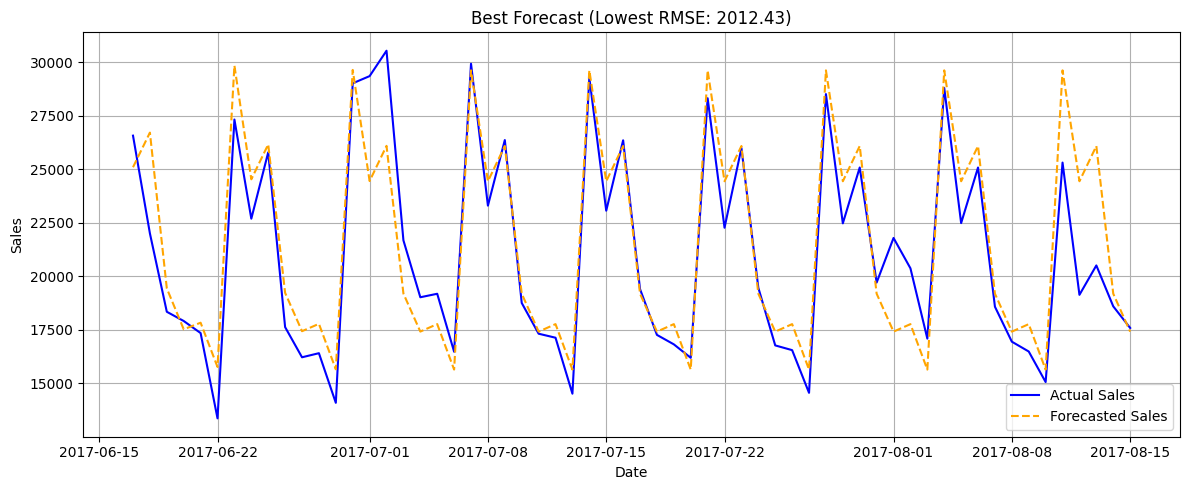

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(best_test_index, best_test_actual, label='Actual Sales', color='blue')
plt.plot(best_test_index, best_forecast, label='Forecasted Sales', color='orange', linestyle='--')
plt.title(f'Best Forecast (Lowest RMSE: {best_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()